7일 간 재반등 횟수로 학습했을 때 가장 높은 점수(MSE 25, R 0.95)

다음으로 상영일수와 상관관계가 높았던 컬럼들 제거하고 진행해보니까 점수는 조금 떨어짐(MSE 62, R 0.87)

7일로 했을 때 가장 높은 이유는 아마 주말과 평일 비율이 모든 샘플에서 동일하게 반영되기 때문으로 추정


컬럼 PCA 압축해서도 진행해봤는데 차이 미미(MSE 66, R 0.86)

아마 랜덤포레스트에서 피처부분집합 크기를 정할 수 있어서 그런 것으로 추정

In [68]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'NanumGothic' # matplotlib 한글깨짐 해결
mpl.rcParams['axes.unicode_minus'] = False

In [69]:
import pandas as pd

pd.set_option('display.max_seq_items', None)

### 전처리

In [70]:
import pandas as pd
file_path = "final_data_rebounds.csv"
df = pd.read_csv(file_path)

In [71]:
cols_to_drop = ['영화명', '개봉일', '장르', '국적', '감독', '배급사', '대표국적', '등급', '제작사', '배우','조회일', '순위', '매출액', '매출액(점유율)', '매출액증감',
       '매출액증감율(전일대비)', '관객수', '관객수증감(전일대비)', '관객수증감율(전일대비)', '스크린수', '상영횟수',]
df = df.drop(columns=cols_to_drop)

In [72]:
df.columns[df.isnull().any()].tolist()

['관객수_volatility',
 '관객수_slope',
 '관객수_peak_offset',
 '관객수_peak_value',
 '관객수_early_peak',
 '스크린수_volatility',
 '스크린수_slope',
 '스크린수_peak_offset',
 '스크린수_peak_value',
 '스크린수_early_peak',
 '상영횟수_volatility',
 '상영횟수_slope',
 '상영횟수_peak_offset',
 '상영횟수_peak_value',
 '상영횟수_early_peak',
 '흥행안정성지수_3일',
 '흥행안정성지수_10일']

In [73]:
df.fillna(df.mean(), inplace=True) # 결측값은 평균으로 채움

## 상관관계 출력

In [68]:
cols_to_drop = [col for col in df.columns if col.startswith("장르_") and not col.endswith("_점수")]
df = df.drop(columns=cols_to_drop)

In [69]:
cols_to_drop = [col for col in df.columns if col.startswith("국적_") and not col.endswith("_점수")]
df = df.drop(columns=cols_to_drop)

In [70]:
# 상영일수와 다른 수치형 피처들 간의 상관관계 계산
correlation_with_target = df.corr()['상영일수'].sort_values(ascending=False)

# 상관관계 출력
print(correlation_with_target)

상영일수                1.000000
재반등횟수               0.956186
스크린수_sum            0.621628
스크린수_sum_after      0.621204
스크린수_max            0.557400
반감기                 0.532989
상영횟수_sum            0.529905
상영횟수_sum_after      0.529573
스크린수_std            0.521161
상영횟수_max            0.493889
상영횟수_std            0.462242
스크린수_mean           0.461510
관객수_sum             0.455266
관객수_sum_after       0.453861
총매출액                0.450921
배급사_매출액_점수          0.426838
배급사_점수              0.423818
10일뒤_재반등횟수          0.421632
상영횟수_mean           0.417301
관객수_max             0.413586
관객수_std             0.400908
7일뒤_재반등횟수           0.397631
관객수_mean            0.382165
스크린수_volatility     0.369887
상영횟수_volatility     0.356737
배급사_영화수_점수          0.354211
관객수_volatility      0.345532
배우_점수               0.336209
배우_매출액_점수           0.331230
스크린수_peak_value     0.320599
장르_상영일수_점수          0.311600
3일뒤_재반등횟수           0.306114
상영횟수_peak_value     0.305883
누적관객수               0.289410
배우_영화수_점수     

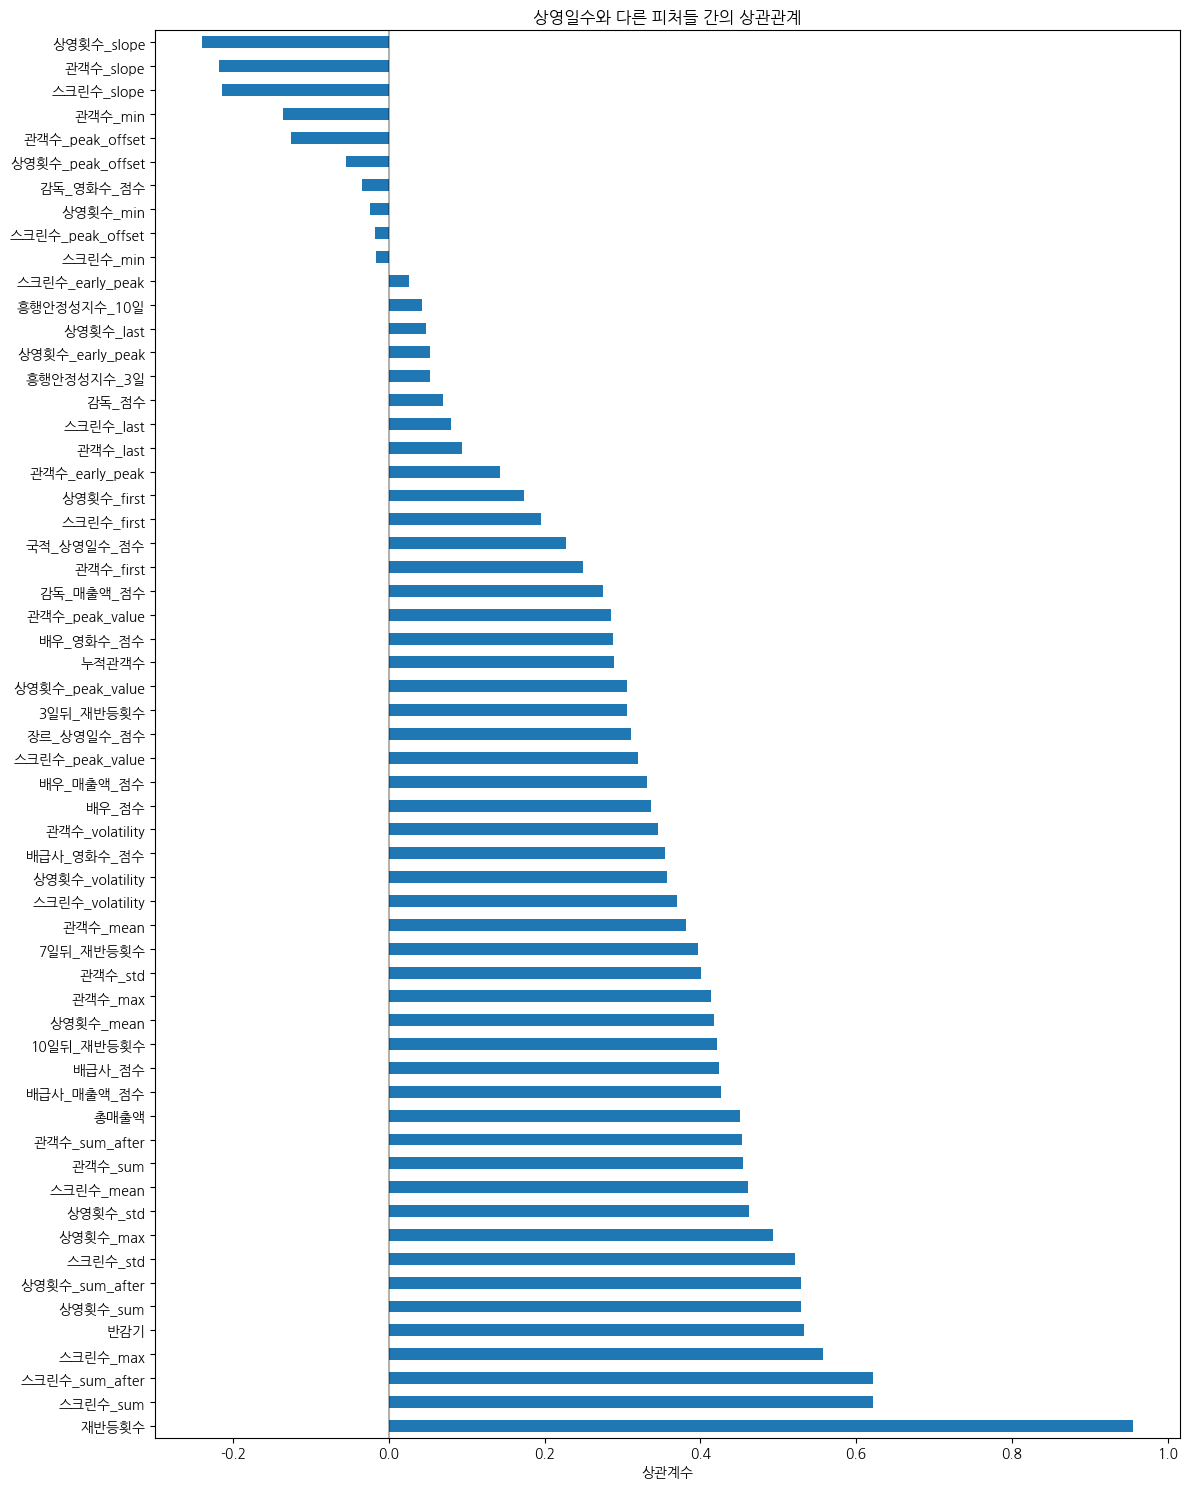

In [71]:
import matplotlib.pyplot as plt

# 상관관계 막대 그래프 - 높이 늘리기
plt.figure(figsize=(12, 15))  # 폭과 높이 모두 늘림
correlation_with_target.drop('상영일수').plot(kind='barh')
plt.xlabel('상관계수')
plt.title('상영일수와 다른 피처들 간의 상관관계')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()  # 레이아웃 자동 조정으로 글자 겹침 방지
plt.show()

전체 재반등횟수는 상관관계가 상당히 높음


반감기, 스크린수, 상영횟수, 관객수의 경우 평균을 제외한 나머지 값이 높은 상관관계를 보였음

이 값들은 당연히 상영일수와 높은 선형 상관관계를 가질 수 밖에 없으므로

제거하고 진행하는 것도 고려해봐야할 것 같음

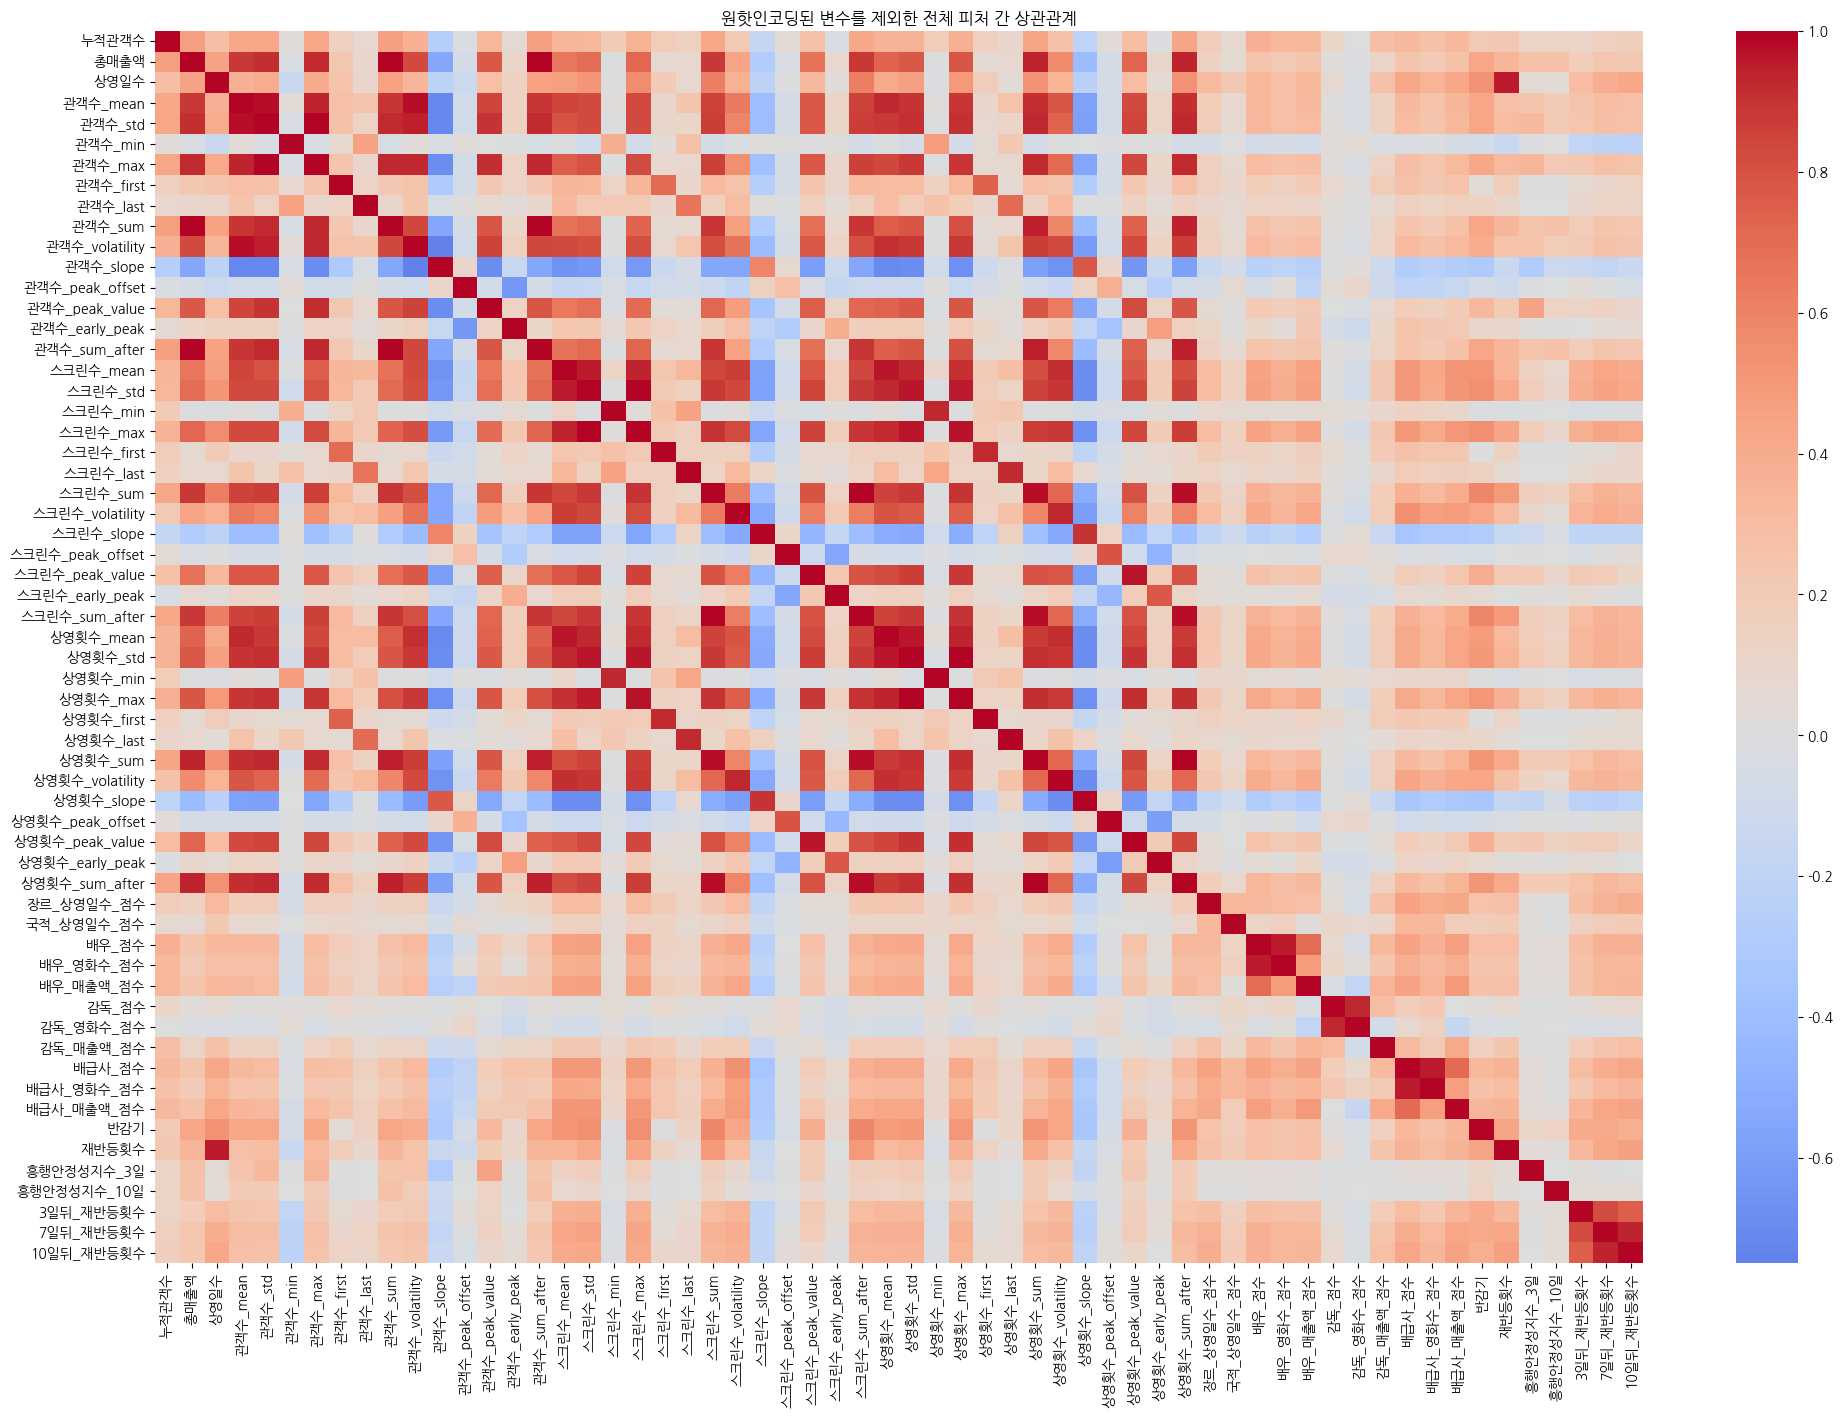

In [73]:
import seaborn as sns

# 전체 상관관계 히트맵
plt.figure(figsize=(24, 16))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('원핫인코딩된 변수를 제외한 전체 피처 간 상관관계')
plt.show()

### 모든 컬럼을 사용했을 때(재반등횟수까지)

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


MSE: 30.2356
R² Score: 0.9401


5.5일 정도의 평균 오차를 가짐

In [26]:
# 피처 중요도 확인
feature_importance = rf_regressor.feature_importances_

# 피처명과 함께 정리
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("피처 중요도 Top 10:")
print(importance_df.head(10))

피처 중요도 Top 10:
            feature  importance
97            재반등횟수    0.834719
99      흥행안정성지수_10일    0.050865
27   스크린수_sum_after    0.012712
21         스크린수_sum    0.011323
6         관객수_first    0.008708
22  스크린수_volatility    0.005236
14    관객수_sum_after    0.005141
8           관객수_sum    0.004784
7          관객수_last    0.004629
96              반감기    0.004295


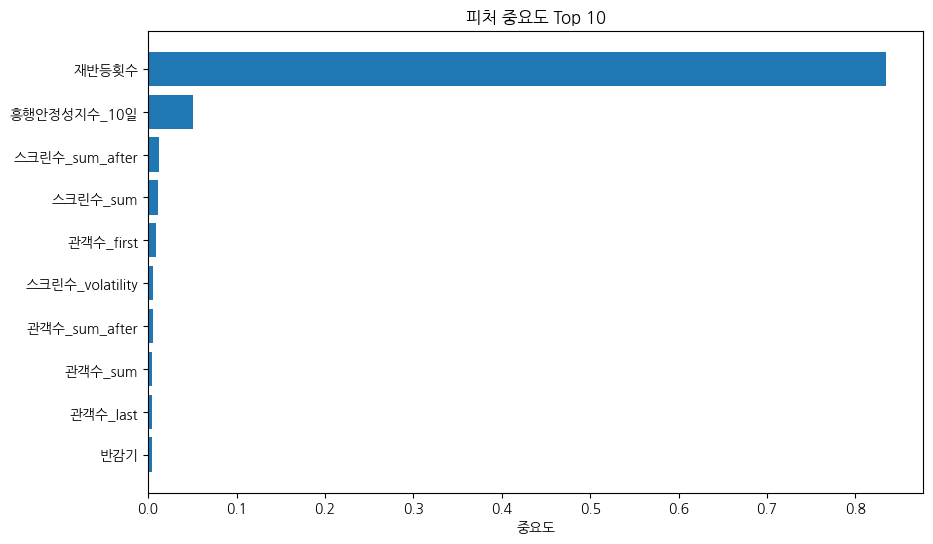

In [29]:
import matplotlib.pyplot as plt

# 상위 10개 피처 시각화
top_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('중요도')
plt.title('피처 중요도 Top 10')
plt.gca().invert_yaxis()
plt.show()


### 전체 재반등 횟수 삭제 후 다시 진행

In [30]:
df = df.drop(columns=["재반등횟수"])

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


MSE: 26.5863
R² Score: 0.9474


In [32]:
# 피처 중요도 확인
feature_importance = rf_regressor.feature_importances_

# 피처명과 함께 정리
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("피처 중요도 Top 10:")
print(importance_df.head(10))

피처 중요도 Top 10:
            feature  importance
27   스크린수_sum_after    0.234546
21         스크린수_sum    0.149612
98      흥행안정성지수_10일    0.076561
22  스크린수_volatility    0.073206
15        스크린수_mean    0.071140
2          관객수_mean    0.054435
96              반감기    0.041194
8           관객수_sum    0.036364
14    관객수_sum_after    0.034648
35  상영횟수_volatility    0.030903


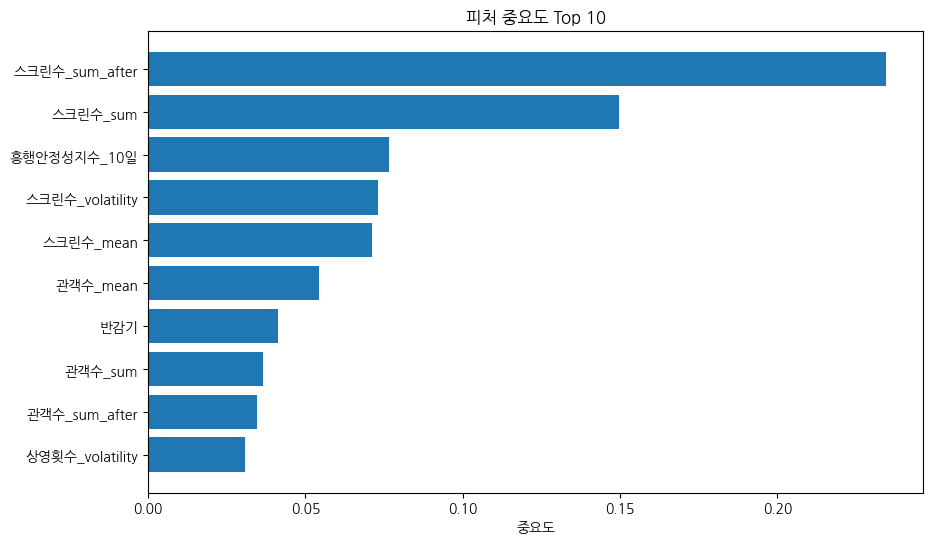

In [ ]:
import matplotlib.pyplot as plt

# 상위 10개 피처 시각화
top_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('중요도')
plt.title('피처 중요도 Top 10')
plt.gca().invert_yaxis()
plt.show()

## 재반등횟수 삭제

가장 상관관계가 높았던 재반등 횟수만 제거

### 재반등횟수 7일로 학습

MSE: 25.0451
R² Score: 0.9504

In [74]:
df = df.drop(columns=["재반등횟수", "3일뒤_재반등횟수", "10일뒤_재반등횟수"])

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [76]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 29.6494
R² Score: 0.9413


In [77]:
## 최고 점수
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    max_features=0.4, 
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 25.0451
R² Score: 0.9504


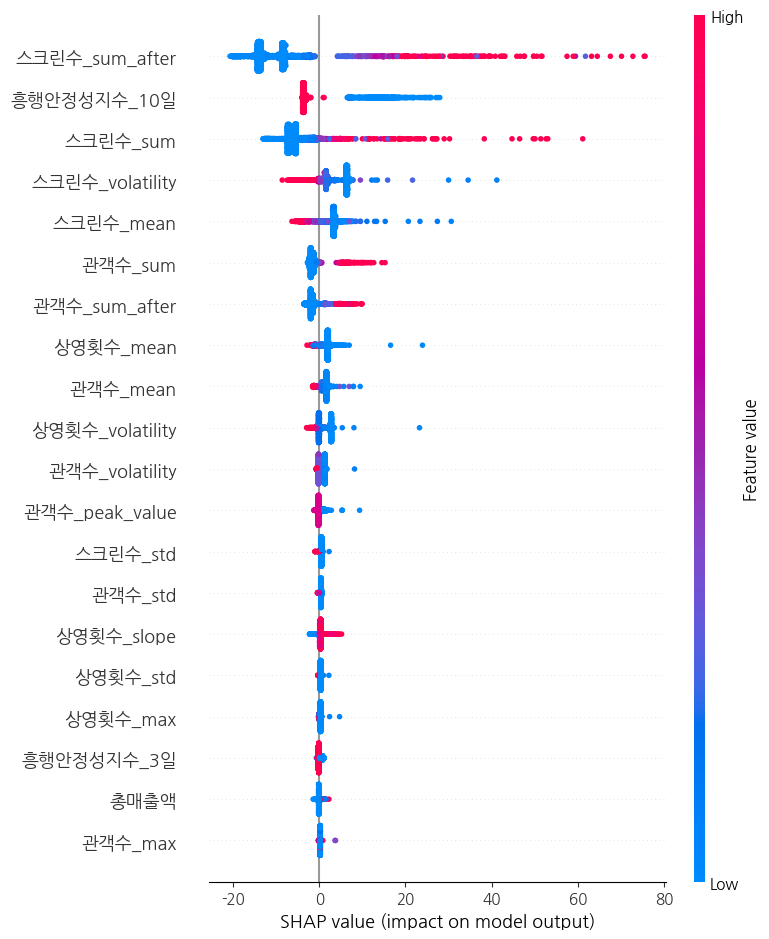

In [11]:
import shap

explainer = shap.TreeExplainer(rf_regressor)  
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### 재등반횟수 10일

MSE: 69.6294
R² Score: 0.8621

In [ ]:
df = df.drop(columns=["반감기", "재반등횟수"])
cols_to_drop = [col for col in df.columns if col.endswith("_sum")]
df = df.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df.columns if col.endswith("_sum_after")]
df = df.drop(columns=cols_to_drop)

In [ ]:
df = df.drop(columns=["3일뒤_재반등횟수", "7일뒤_재반등횟수"])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 74.2396
R² Score: 0.8530


In [ ]:
## 7일을 사용했을 때 최고 점수였던 파라미터로 재실험
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    max_features=0.4, 
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 69.6294
R² Score: 0.8621


### 재반등횟수 3일

MSE: 63.0609
R² Score: 0.8751

In [ ]:
df = df.drop(columns=["반감기", "재반등횟수"])
cols_to_drop = [col for col in df.columns if col.endswith("_sum")]
df = df.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df.columns if col.endswith("_sum_after")]
df = df.drop(columns=cols_to_drop)

In [ ]:
df = df.drop(columns=["10일뒤_재반등횟수", "7일뒤_재반등횟수"])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 74.4022
R² Score: 0.8527


In [ ]:
## 7일을 사용했을 때 최고 점수였던 파라미터로 재실험
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    max_features=0.4, 
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 63.0609
R² Score: 0.8751


## _sum, _sum_after, 재반등횟수, 반감기 삭제

상영일수와 높은 상관관계를 가진 컬럼들을 임의로 제거


### 제거하는 코드

In [17]:
df = df.drop(columns=["반감기", "재반등횟수"])
cols_to_drop = [col for col in df.columns if col.endswith("_sum")]
df = df.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df.columns if col.endswith("_sum_after")]
df = df.drop(columns=cols_to_drop)

In [18]:
df.columns

Index(['누적관객수', '총매출액', '상영일수', '관객수_mean', '관객수_std', '관객수_min', '관객수_max',
       '관객수_first', '관객수_last', '관객수_volatility', '관객수_slope',
       '관객수_peak_offset', '관객수_peak_value', '관객수_early_peak', '스크린수_mean',
       '스크린수_std', '스크린수_min', '스크린수_max', '스크린수_first', '스크린수_last',
       '스크린수_volatility', '스크린수_slope', '스크린수_peak_offset', '스크린수_peak_value',
       '스크린수_early_peak', '상영횟수_mean', '상영횟수_std', '상영횟수_min', '상영횟수_max',
       '상영횟수_first', '상영횟수_last', '상영횟수_volatility', '상영횟수_slope',
       '상영횟수_peak_offset', '상영횟수_peak_value', '상영횟수_early_peak', '장르_SF',
       '장르_가족', '장르_공연', '장르_공연실황', '장르_공포', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리',
       '장르_드라마', '장르_멜로/로맨스', '장르_모험', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극',
       '장르_서부', '장르_서부극', '장르_서부극(웨스턴)', '장르_서사', '장르_성인물(에로)', '장르_스릴러',
       '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_콘서트', '장르_판타지',
       '장르_상영일수_점수', '국적_Other', '국적_네덜란드', '국적_독일', '국적_미국', '국적_스웨덴',
       '국적_스위스', '국적_스페인', '국적_영국', '국적

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 75.1317
R² Score: 0.8512


In [20]:
# 피처 중요도 확인
feature_importance = rf_regressor.feature_importances_

# 피처명과 함께 정리
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("피처 중요도 Top 10:")
print(importance_df.head(10))

피처 중요도 Top 10:
            feature  importance
1              총매출액    0.390889
2          관객수_mean    0.102518
91      흥행안정성지수_10일    0.098043
8    관객수_volatility    0.087669
24        상영횟수_mean    0.036719
0             누적관객수    0.027262
31       상영횟수_slope    0.021502
19  스크린수_volatility    0.021154
3           관객수_std    0.017207
13        스크린수_mean    0.014430


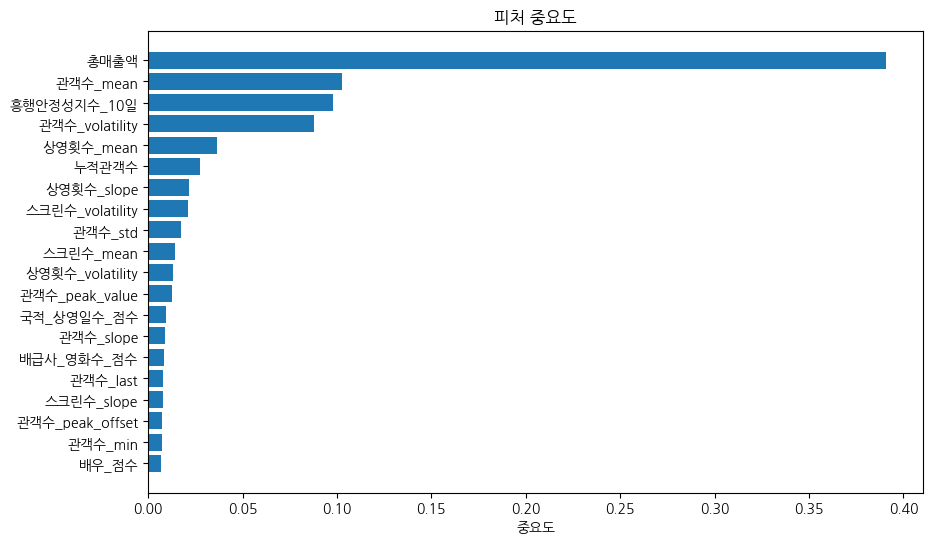

In [21]:
import matplotlib.pyplot as plt

top_features = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('중요도')
plt.title('피처 중요도')
plt.gca().invert_yaxis()
plt.show()

### 재반등횟수 7일로 학습

MSE: 62.3338
R² Score: 0.8766

In [22]:
df = df.drop(columns=["3일뒤_재반등횟수", "10일뒤_재반등횟수"])

In [23]:
df.columns

Index(['누적관객수', '총매출액', '상영일수', '관객수_mean', '관객수_std', '관객수_min', '관객수_max',
       '관객수_first', '관객수_last', '관객수_volatility', '관객수_slope',
       '관객수_peak_offset', '관객수_peak_value', '관객수_early_peak', '스크린수_mean',
       '스크린수_std', '스크린수_min', '스크린수_max', '스크린수_first', '스크린수_last',
       '스크린수_volatility', '스크린수_slope', '스크린수_peak_offset', '스크린수_peak_value',
       '스크린수_early_peak', '상영횟수_mean', '상영횟수_std', '상영횟수_min', '상영횟수_max',
       '상영횟수_first', '상영횟수_last', '상영횟수_volatility', '상영횟수_slope',
       '상영횟수_peak_offset', '상영횟수_peak_value', '상영횟수_early_peak', '장르_SF',
       '장르_가족', '장르_공연', '장르_공연실황', '장르_공포', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리',
       '장르_드라마', '장르_멜로/로맨스', '장르_모험', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극',
       '장르_서부', '장르_서부극', '장르_서부극(웨스턴)', '장르_서사', '장르_성인물(에로)', '장르_스릴러',
       '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_콘서트', '장르_판타지',
       '장르_상영일수_점수', '국적_Other', '국적_네덜란드', '국적_독일', '국적_미국', '국적_스웨덴',
       '국적_스위스', '국적_스페인', '국적_영국', '국적

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [25]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 79.1949
R² Score: 0.8432


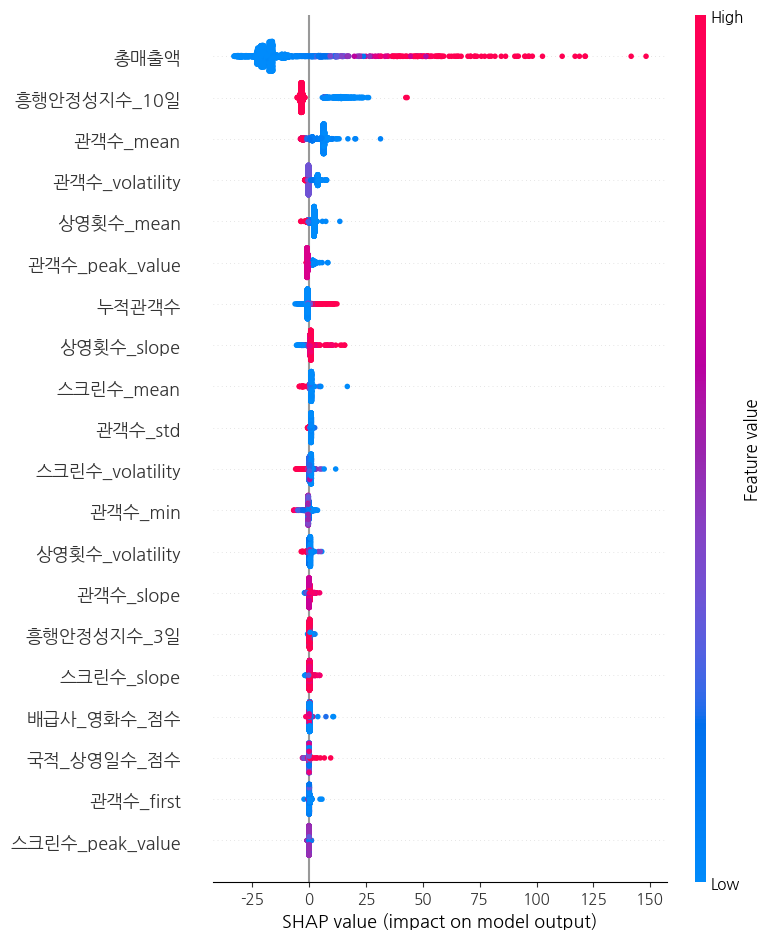

In [26]:
import shap

explainer = shap.TreeExplainer(rf_regressor)  
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200, # 200에서 더 올려도 변화 없음
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 66.9537
R² Score: 0.8674


In [ ]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, # 더 높여도 변화없음
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 64.4316
R² Score: 0.8724


In [ ]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    min_samples_split=10, # 기본값이 제일 나음
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 69.7072
R² Score: 0.8620


In [161]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    max_features=0.25, 
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 64.4248
R² Score: 0.8724


In [ ]:
## 최고 점수
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    max_features=0.4, 
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 62.3338
R² Score: 0.8766


### 재등반횟수 10일

MSE: 69.6294
R² Score: 0.8621

In [204]:
df = df.drop(columns=["반감기", "재반등횟수"])
cols_to_drop = [col for col in df.columns if col.endswith("_sum")]
df = df.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df.columns if col.endswith("_sum_after")]
df = df.drop(columns=cols_to_drop)

In [205]:
df = df.drop(columns=["3일뒤_재반등횟수", "7일뒤_재반등횟수"])

In [206]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [207]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 74.2396
R² Score: 0.8530


In [208]:
## 7일을 사용했을 때 최고 점수였던 파라미터로 재실험
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    max_features=0.4, 
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 69.6294
R² Score: 0.8621


### 재반등횟수 3일

MSE: 63.0609
R² Score: 0.8751

In [213]:
df = df.drop(columns=["반감기", "재반등횟수"])
cols_to_drop = [col for col in df.columns if col.endswith("_sum")]
df = df.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df.columns if col.endswith("_sum_after")]
df = df.drop(columns=cols_to_drop)

In [214]:
df = df.drop(columns=["10일뒤_재반등횟수", "7일뒤_재반등횟수"])

In [215]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 피처와 타겟 분리
X = df.drop('상영일수', axis=1) 
y = df['상영일수']

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [216]:
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 74.4022
R² Score: 0.8527


In [217]:
## 7일을 사용했을 때 최고 점수였던 파라미터로 재실험
# 회귀용 Random Forest
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30, 
    max_features=0.4, 
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# 회귀 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 63.0609
R² Score: 0.8751
